In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import time


In [3]:
import os
import numpy as np
import struct

# Paths to binary files
train_images_path = '/kaggle/input/mnist-dataset/train-images.idx3-ubyte'
train_labels_path = '/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'
test_images_path = '/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_path = '/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte'

# Function to load MNIST data from ubyte files
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
        return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

# Load data
x_train = load_mnist_images(train_images_path)
y_train = load_mnist_labels(train_labels_path)
x_test = load_mnist_images(test_images_path)
y_test = load_mnist_labels(test_labels_path)

# Normalize pixel values to [0, 1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [4]:
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),  # Input layer
        Dense(128, activation='relu'),  # Hidden layer
        Dense(64, activation='relu'),   # Hidden layer
        Dense(10, activation='softmax') # Output layer
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [5]:
# Sequential version
model_seq = create_model()

start_time = time.time()
model_seq.fit(x_train, y_train, epochs=10, batch_size=64, verbose=2)
seq_time = time.time() - start_time

loss_seq, acc_seq = model_seq.evaluate(x_test, y_test, verbose=0)
print(f"Sequential Training Time: {seq_time:.2f}s, Accuracy: {acc_seq:.4f}")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
938/938 - 4s - 5ms/step - accuracy: 0.9191 - loss: 0.2835
Epoch 2/10
938/938 - 3s - 3ms/step - accuracy: 0.9641 - loss: 0.1201
Epoch 3/10
938/938 - 3s - 3ms/step - accuracy: 0.9754 - loss: 0.0818
Epoch 4/10
938/938 - 3s - 3ms/step - accuracy: 0.9813 - loss: 0.0620
Epoch 5/10
938/938 - 3s - 3ms/step - accuracy: 0.9856 - loss: 0.0477
Epoch 6/10
938/938 - 3s - 4ms/step - accuracy: 0.9880 - loss: 0.0380
Epoch 7/10
938/938 - 3s - 3ms/step - accuracy: 0.9904 - loss: 0.0301
Epoch 8/10
938/938 - 3s - 3ms/step - accuracy: 0.9915 - loss: 0.0255
Epoch 9/10
938/938 - 3s - 3ms/step - accuracy: 0.9928 - loss: 0.0223
Epoch 10/10
938/938 - 3s - 4ms/step - accuracy: 0.9944 - loss: 0.0180
Sequential Training Time: 32.39s, Accuracy: 0.9756


In [6]:
strategy = tf.distribute.MirroredStrategy()  # Leverage multiple GPUs if available

with strategy.scope():
    model_par = create_model()

start_time = time.time()
model_par.fit(x_train, y_train, epochs=10, batch_size=64, verbose=2)
par_time = time.time() - start_time

loss_par, acc_par = model_par.evaluate(x_test, y_test, verbose=0)
print(f"Parallel Training Time: {par_time:.2f}s, Accuracy: {acc_par:.4f}")


Epoch 1/10
938/938 - 5s - 5ms/step - accuracy: 0.9202 - loss: 0.2747
Epoch 2/10
938/938 - 4s - 4ms/step - accuracy: 0.9652 - loss: 0.1169
Epoch 3/10
938/938 - 4s - 4ms/step - accuracy: 0.9749 - loss: 0.0817
Epoch 4/10
938/938 - 4s - 4ms/step - accuracy: 0.9818 - loss: 0.0608
Epoch 5/10
938/938 - 4s - 4ms/step - accuracy: 0.9852 - loss: 0.0489
Epoch 6/10
938/938 - 3s - 4ms/step - accuracy: 0.9883 - loss: 0.0376
Epoch 7/10
938/938 - 4s - 4ms/step - accuracy: 0.9899 - loss: 0.0319
Epoch 8/10
938/938 - 4s - 4ms/step - accuracy: 0.9909 - loss: 0.0266
Epoch 9/10
938/938 - 4s - 4ms/step - accuracy: 0.9931 - loss: 0.0213
Epoch 10/10
938/938 - 4s - 4ms/step - accuracy: 0.9937 - loss: 0.0206
Parallel Training Time: 38.19s, Accuracy: 0.9754


Sequential Training Time: 32.39 seconds
Parallel Training Time: 38.19 seconds


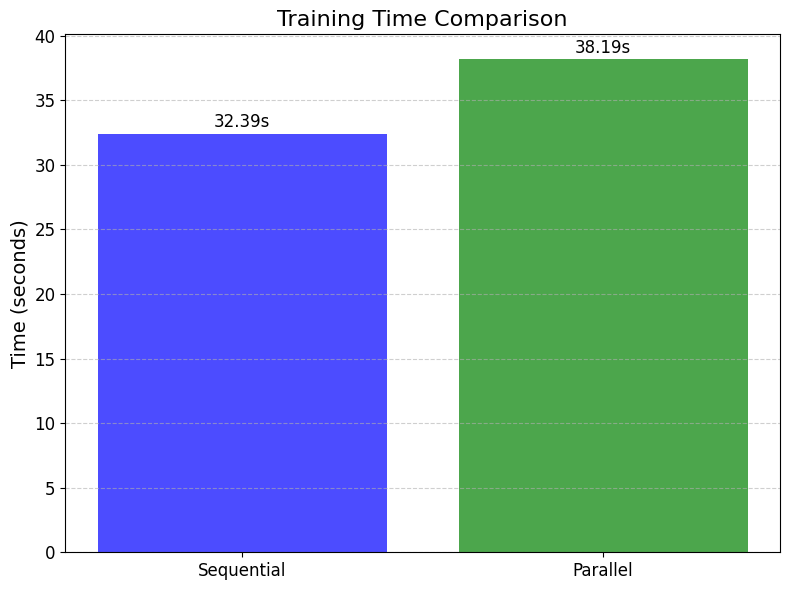

In [7]:
import matplotlib.pyplot as plt

# Display times in text
print(f"Sequential Training Time: {seq_time:.2f} seconds")
print(f"Parallel Training Time: {par_time:.2f} seconds")

# Create a bar graph for time comparison
methods = ['Sequential', 'Parallel']
times = [seq_time, par_time]

plt.figure(figsize=(8, 6))
plt.bar(methods, times, color=['blue', 'green'], alpha=0.7)
plt.title('Training Time Comparison', fontsize=16)
plt.ylabel('Time (seconds)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate time values on the bars
for i, time in enumerate(times):
    plt.text(i, time + 0.5, f"{time:.2f}s", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Sequential Training Time: 32.39 seconds, Accuracy: 0.9756, MAE: 0.0977
Parallel Training Time: 38.19 seconds, Accuracy: 0.9754, MAE: 0.0899


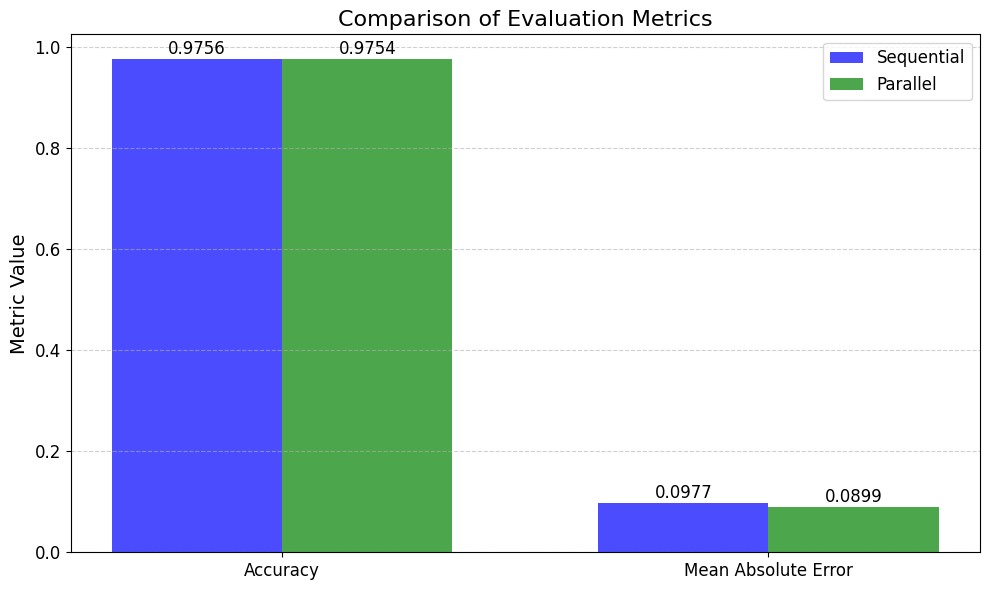

In [8]:
# Evaluation Metrics - Accuracy and Mean Absolute Error (MAE)

from sklearn.metrics import mean_absolute_error

# Sequential Evaluation
y_pred_seq = model_seq.predict(x_test, verbose=0)
mae_seq = mean_absolute_error(y_test.argmax(axis=1), y_pred_seq.argmax(axis=1))

print(f"Sequential Training Time: {seq_time:.2f} seconds, Accuracy: {acc_seq:.4f}, MAE: {mae_seq:.4f}")

# Parallel Evaluation
y_pred_par = model_par.predict(x_test, verbose=0)
mae_par = mean_absolute_error(y_test.argmax(axis=1), y_pred_par.argmax(axis=1))

print(f"Parallel Training Time: {par_time:.2f} seconds, Accuracy: {acc_par:.4f}, MAE: {mae_par:.4f}")

# Comparison Visualization - Accuracy & MAE

metrics = ['Accuracy', 'Mean Absolute Error']
seq_metrics = [acc_seq, mae_seq]
par_metrics = [acc_par, mae_par]

x = range(len(metrics))  # Number of metrics

plt.figure(figsize=(10, 6))

# Accuracy & MAE comparison bar chart
width = 0.35  # Width of bars

# Plot sequential and parallel metrics side by side
plt.bar([i - width / 2 for i in x], seq_metrics, width=width, label='Sequential', color='blue', alpha=0.7)
plt.bar([i + width / 2 for i in x], par_metrics, width=width, label='Parallel', color='green', alpha=0.7)

# Chart settings
plt.title('Comparison of Evaluation Metrics', fontsize=16)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(x, metrics, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Annotate values on bars
for i, (seq, par) in enumerate(zip(seq_metrics, par_metrics)):
    plt.text(i - width / 2, seq + 0.01, f"{seq:.4f}", ha='center', fontsize=12)
    plt.text(i + width / 2, par + 0.01, f"{par:.4f}", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
938/938 - 4s - 4ms/step - accuracy: 0.9190 - loss: 0.2856
Epoch 2/100
938/938 - 3s - 3ms/step - accuracy: 0.9640 - loss: 0.1199
Epoch 3/100
938/938 - 3s - 3ms/step - accuracy: 0.9742 - loss: 0.0838
Epoch 4/100
938/938 - 3s - 3ms/step - accuracy: 0.9808 - loss: 0.0629
Epoch 5/100
938/938 - 3s - 3ms/step - accuracy: 0.9844 - loss: 0.0497
Epoch 6/100
938/938 - 3s - 3ms/step - accuracy: 0.9867 - loss: 0.0408
Epoch 7/100
938/938 - 3s - 3ms/step - accuracy: 0.9900 - loss: 0.0318
Epoch 8/100
938/938 - 3s - 3ms/step - accuracy: 0.9912 - loss: 0.0265
Epoch 9/100
938/938 - 3s - 3ms/step - accuracy: 0.9921 - loss: 0.0234
Epoch 10/100
938/938 - 3s - 3ms/step - accuracy: 0.9944 - loss: 0.0173
Epoch 11/100
938/938 - 3s - 3ms/step - accuracy: 0.9942 - loss: 0.0172
Epoch 12/100
938/938 - 3s - 3ms/step - accuracy: 0.9945 - loss: 0.0163
Epoch 13/100
938/938 - 3s - 3ms/step - accuracy: 0.9951 - loss: 0.0136
Epoch 14/100
938/938 - 3s - 3ms/step - accuracy: 0.9964 - loss: 0.0114
Epoch 15/100
93

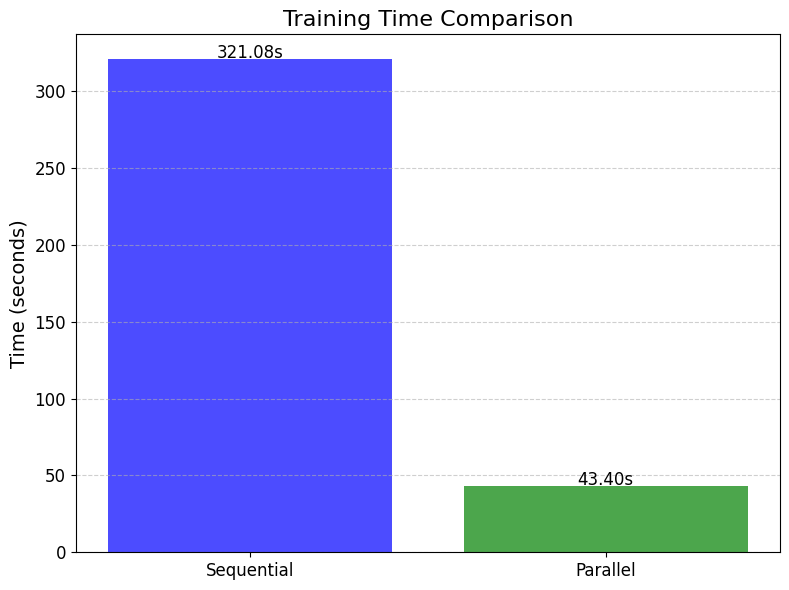

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import time

# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Define the model
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train the sequential version
model_seq = create_model()
start_time_seq = time.time()
model_seq.fit(x_train, y_train, epochs=100, batch_size=64, verbose=2)
time_seq = time.time() - start_time_seq

# Train the parallel version using MirroredStrategy
strategy = tf.distribute.MirroredStrategy()  # Leverage multiple GPUs if available
with strategy.scope():
    model_par = create_model()
start_time_par = time.time()
model_par.fit(x_train, y_train, epochs=10, batch_size=64, verbose=2)
time_par = time.time() - start_time_par

# Evaluate both models
loss_seq, acc_seq = model_seq.evaluate(x_test, y_test, verbose=0)
loss_par, acc_par = model_par.evaluate(x_test, y_test, verbose=0)

# Display results as text
print(f"Sequential Training Time: {time_seq:.2f} seconds, Accuracy: {acc_seq:.4f}")
print(f"Parallel Training Time: {time_par:.2f} seconds, Accuracy: {acc_par:.4f}")

# Visualize the results in a bar graph
methods = ['Sequential', 'Parallel']
times = [time_seq, time_par]

plt.figure(figsize=(8, 6))
plt.bar(methods, times, color=['blue', 'green'], alpha=0.7)
plt.title('Training Time Comparison', fontsize=16)
plt.ylabel('Time (seconds)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate time values on the bars
for i, time_val in enumerate(times):
    plt.text(i, time_val + 0.5, f"{time_val:.2f}s", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Sequential Training Time: 321.08 seconds, Accuracy: 0.9783, MAE: 0.0761
Parallel Training Time: 43.40 seconds, Accuracy: 0.9770, MAE: 0.0891


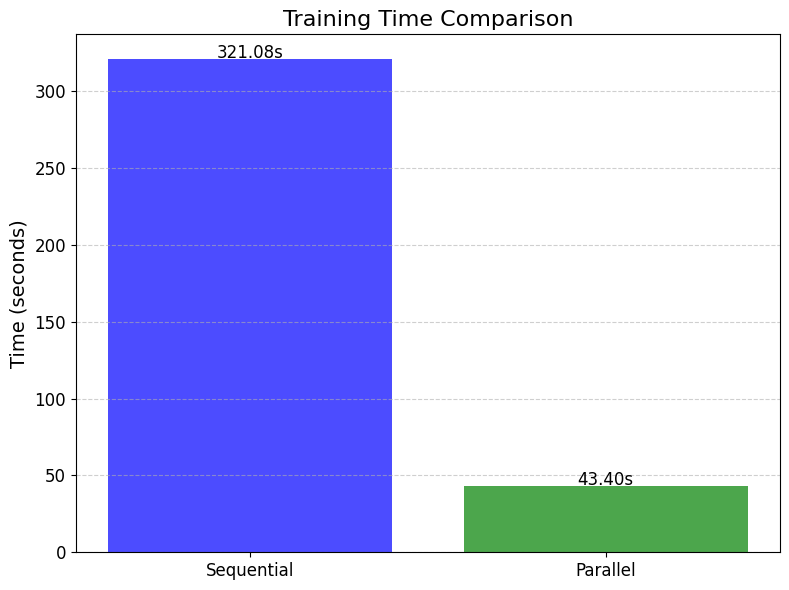

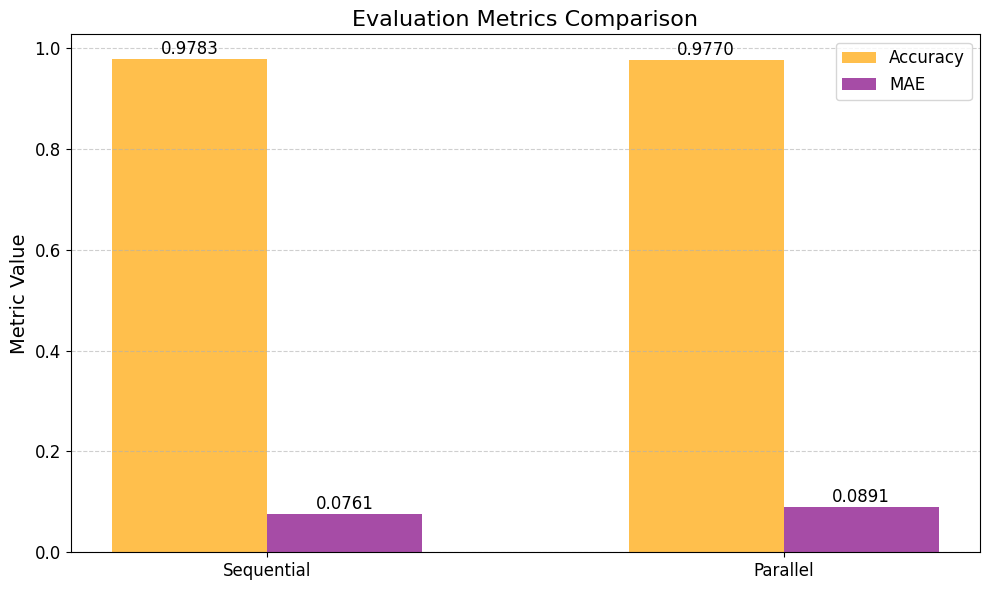

In [10]:
# Import necessary libraries
from sklearn.metrics import mean_absolute_error

# Evaluate the models on test data
y_pred_seq = model_seq.predict(x_test, verbose=0).argmax(axis=1)
y_true_seq = y_test.argmax(axis=1)
mae_seq = mean_absolute_error(y_true_seq, y_pred_seq)

y_pred_par = model_par.predict(x_test, verbose=0).argmax(axis=1)
y_true_par = y_test.argmax(axis=1)
mae_par = mean_absolute_error(y_true_par, y_pred_par)

# Display results as text
print(f"Sequential Training Time: {time_seq:.2f} seconds, Accuracy: {acc_seq:.4f}, MAE: {mae_seq:.4f}")
print(f"Parallel Training Time: {time_par:.2f} seconds, Accuracy: {acc_par:.4f}, MAE: {mae_par:.4f}")

# Visualize the results in bar graphs for training time and evaluation metrics
methods = ['Sequential', 'Parallel']
times = [time_seq, time_par]
accuracies = [acc_seq, acc_par]
maes = [mae_seq, mae_par]

# Plot training time comparison
plt.figure(figsize=(8, 6))
plt.bar(methods, times, color=['blue', 'green'], alpha=0.7)
plt.title('Training Time Comparison', fontsize=16)
plt.ylabel('Time (seconds)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate time values on the bars
for i, time_val in enumerate(times):
    plt.text(i, time_val + 0.5, f"{time_val:.2f}s", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot evaluation metrics comparison
x = range(len(methods))
width = 0.3  # Width of the bars

plt.figure(figsize=(10, 6))

# Plot accuracy
plt.bar([i - width / 2 for i in x], accuracies, width=width, label='Accuracy', color='orange', alpha=0.7)

# Plot MAE
plt.bar([i + width / 2 for i in x], maes, width=width, label='MAE', color='purple', alpha=0.7)

# Chart settings
plt.title('Evaluation Metrics Comparison', fontsize=16)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(x, methods, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Annotate values on the bars
for i, (acc, mae) in enumerate(zip(accuracies, maes)):
    plt.text(i - width / 2, acc + 0.01, f"{acc:.4f}", ha='center', fontsize=12)
    plt.text(i + width / 2, mae + 0.01, f"{mae:.4f}", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
